In [11]:
# from analysis.moment_analysis import ModelsContainer
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import os

import pickle


from energyflow.archs.moment import EFN_moment, PFN_moment
from ModelsContainer import ModelsContainer

try:
    from rikabplotlib.plot_utils import newplot, stamp, add_whitespace
except:
    from utils.plot_utils import newplot, stamp, add_whitespace



from utils.data_utils import load_data
from energyflow.archs.moment_layers import Moment

import tensorflow as tf




In [12]:
pfn_string = "EFN"
dataset = "qg"
run_name = "latent"
NEW_FORMAT = False 

num_models_to_train = 3 ##number of models to use to make error bars
order_list = [1,2, 3, 4] #
input_dim = 2
output_dim = 1
F_width = 25
Phi_width = 25


performance = {}
configs = {}
histories = {}


# Directory Handling
base_directory = f"Data/{dataset}_{pfn_string}_{run_name}"
plot_directory = f"Plots/{dataset}_{pfn_string}_{run_name}"
latent_directory = os.path.join(plot_directory, "latent_spaces")
os.makedirs(plot_directory, exist_ok = True)
os.makedirs(latent_directory, exist_ok = True)


for k in order_list:

    directory = os.path.join(base_directory, f"order_{k}")


    p = np.load(os.path.join(directory , "performance.npy"), allow_pickle=True)[()]
    h = np.load(os.path.join(directory ,"histories.npy"), allow_pickle=True)[()]

    try:
        c = np.load(os.path.join(directory , "configs.npy"), allow_pickle=True)[()]
        configs.update(c)
    except Exception as e:
        print("Config Loading Failed", e)


    if NEW_FORMAT:
        performance[f"{k}"] = p
        histories[f"{k}"] = h
    else:
        performance.update(p)
        histories.update(h)


# String formatting
dataset_string = "Top/QCD" if dataset == "top" else "Quark/Gluon"
is_EFN = True if pfn_string == "EFN" else False
categorical = False

# # Load Test Data
# (X_train, X_val, X_test,), (Y_train, Y_val, Y_test,) = load_data(dataset, 2, 2, 5000, 
#                                                                  EFN_format=is_EFN, 
#                                                                  categorical=categorical)

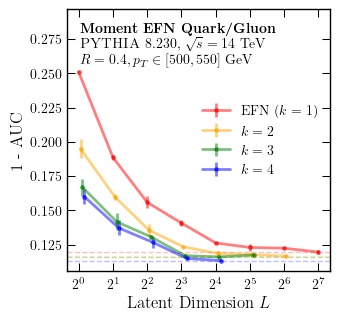

In [13]:
# print(histories.keys())

# colors = ["red", "orange", "green", "blue"]
# fig, axes = plt.subplots(1, 1, figsize=(8,8))
# plt.rcParams['font.size'] = '20'

# print(configs)0


def effective_latent_dim(O, L):

    binom = scipy.special.binom(L+O, O+1)
    return int( (O+1) * binom / L)

# def dictionary_substring(dict, substring):

#     for key in dict:
#         if substring in key:
#             return dict[key]

# for (o,order) in enumerate(histories):
#     for sample in range(num_samples):
#         for model in range(num_models_to_train)[:1]:

#             print(order, sample, model, histories[order][sample][model].keys())
#             plt.plot(dictionary_substring(histories[order][sample][model], "val_auc"), color = colors[o], alpha = 0.25, lw = 3)


# plt.xlabel("epochs")


def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue", "purple", "black"]

    fig, ax = newplot("column")
    # plt.rcParams['font.size'] = '20'



    # AUC Plot Data
    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []


        if NEW_FORMAT:


            aucs = performance_dict[f"{order}"]
            x = np.power(2, np.arange(0, aucs.shape[0]))[::-1]
       
            # remove outliers for PFN
            if pfn_string == "PFN" and order == 4:
                print(aucs)
                aucs[3,2] = aucs[3,1]
                # x = x[:2]

            y = np.mean(aucs, axis = 1)
            yerr = np.std(aucs, axis = 1)
            print(y)

        else:
            for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):
                
                x.append(config[0])
                # x.append(latent_dim(order,  config[0]))
                # x.append(effective_l.atent_dim(order,  config[0]))


                y.append(info[1])
                yerr.append(info[2])
                
            # axes.scatter(x, y,  marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5)
            x = np.asarray(x)
            y = np.asarray(y)
        

        # Add data to plot
        ax.errorbar(x * (1 + p / 25),1-y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else pfn_string + " ($k = 1$)", alpha = 0.5, lw = 2)

        min_y = np.min(1-y)
        min_x = np.argmin(1-y)
        plt.axhline(min_y, c=colors[p], ls = "--", alpha = 0.25)


        
        # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])

    # Stamp
    
    add_whitespace(ax, upper_fraction=1.15,)


    line_0 = f"Moment {pfn_string} {dataset_string}"
    line_1 = r"$\textsc{PYTHIA}$ $8.215 + \textsc{DELPHES}$, $\sqrt{s} = 14$ TeV" if dataset == "top" else r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
    line_2 = "$R = 0.8, p_T \in [550, 650]$ GeV" if dataset == "top" else "$R = 0.4, p_T \in [500, 550]$ GeV"
    line_3 = r""

    if dataset == "top":
        line_1 = r"$\textsc{PYTHIA}$ $8.215 + \textsc{DELPHES}$"
        line_2 = r"$\sqrt{s} = 14$ TeV"
        line_3 = r"$R = 0.8, p_T \in [550, 650]$ GeV"



    stamp(0.05, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, delta_y= 0.06, textops_update={"horizontalalignment" : "left"})


    plt.legend(frameon = False, loc = "center right")
    plt.xlabel(r"Latent Dimension $L$")
    plt.ylabel("1 - AUC")
    plt.xscale("log", base = 2)
    # plt.ylim(.120, .325)
    plt.xticks((1, 2, 4, 8, 16, 32, 64, 128), [f"$2^{i}$" for i in range(8)])
    # plt.title(f"Moment {pfn_string} {dataset_string} Discrimination")




    plt.savefig(os.path.join(plot_directory, f"{dataset}_{pfn_string}_latent_dim.pdf"), bbox_inches = "tight")
    plt.show()


plot(performance)

In [14]:
# # ROC Table Information

# if NEW_FORMAT:
#     x = [1, 2, 4, 8, 16, 32, 64, 128][::-1]

#     bg = "g" if dataset == "qg" else "qcd"
#     sg = "q" if dataset == "qg" else "top"

#     print(r"\begin{table*}[tph]")
#     print(r"    \centering")
#     print(r"    \begin{tabular}{l|c|c|c|c}")
#     print(rf"         Model & AUC & $1/\epsilon_{bg}$ at $\epsilon_{sg} = 0.3$ & $1/\epsilon_{bg}$ at $\epsilon_{sg} = 0.5$ & Trainable Parameters \\")
#     print(r"         \hline")
#     print(r"         \hline")


#     for L in x:

#         for order in order_list:
#             aucs = []
#             e30 = []
#             e50 = []

      


#             if L == 1 or L == 2**(8-order) or (L == 4 and k == 1):
#                 latex_line = f"$k = {order}, L = {L}$ {'Moment' if order > 1 else ''} {pfn_string}&"  # Start the LaTeX line
#                 for model_index in range(num_models_to_train):
#                     model_dir = os.path.join(base_directory, f"order_{order}", "Models")
#                     model_name = f"O{order}_L{L}_2Phi{100}_3F{100}"
#                     model = tf.keras.models.load_model(os.path.join(model_dir , model_name + f"_{model_index}.keras"), custom_objects={'Moment': Moment})
                    
#                     num_parameters = model.count_params()

#                     # Quark acceptance vs gluon rejection
#                     Y_pred = model.predict(X_test, verbose = 0)

#                     fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred)
#                     auc = roc_auc_score(Y_test, Y_pred)
#                     aucs.append(auc)

#                     e30.append(1/np.interp(0.3, tpr, fpr))
#                     e50.append(1/np.interp(0.5, tpr, fpr))

#                 aucs = np.asarray(aucs)
#                 e30 = np.asarray(e30)
#                 e50 = np.asarray(e50)

#                 # Format for LaTeX table
#                 latex_line += f" {np.mean(aucs):.3f} $\pm$ {np.std(aucs)/np.sqrt(1):.3f} & {np.mean(e30):.1f} $\pm$ {np.std(e30)/np.sqrt(num_models_to_train):.1f} & {np.mean(e50):.1f} $\pm$ {np.std(e50)/np.sqrt(num_models_to_train):.1f} & {num_parameters} \\\\"
#                 print(latex_line)

#             if L == 1 and order ==4:
#                 print("\hline")
#                 print("\hline")


#     print("\hline")
#     print("\hline")


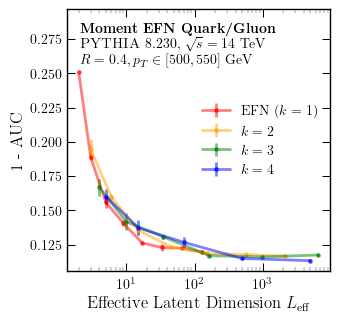

In [15]:
def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue", "purple", "black"]

    fig, ax = newplot("column")
    # plt.rcParams['font.size'] = '20'




    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        if NEW_FORMAT:
            aucs = performance_dict[f"{order}"]
            x_temp = np.power(2, np.arange(0, aucs.shape[0]))[::-1]
            # Calculate effective latent dimension
            x = np.asarray([effective_latent_dim(order,  L) for L in x_temp])


            # remove outliers for PFN
            if pfn_string == "PFN" and order == 4:
                print(aucs)
                aucs[3,2] = aucs[3,1]

                
            y = np.mean(aucs, axis = 1)
            yerr = np.std(aucs, axis = 1)

        else:
            for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):
                
                # x.append(config[0])
                # x.append(latent_dim(order,  config[0]))
                x.append(effective_latent_dim(order,  config[0]))


                y.append(info[1])
                yerr.append(info[2])    
            
        x = np.asarray(x)
        y = np.asarray(y)
        ax.errorbar(x,1 -y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else pfn_string + " ($k = 1$)", alpha = 0.5, lw = 2)


    # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])


    plt.legend(frameon = False, loc = "center right")
    plt.xlabel(r"Effective Latent Dimension $L_{\mathrm{eff}}$")
    plt.ylabel("1 - AUC")
    plt.xscale("log")
    # plt.ylim(.120, .325)
    # plt.title(f"Moment {pfn_string} {dataset_string} Discrimination")

    # Stamp
    add_whitespace(ax, upper_fraction=1.15,)
    line_0 = f"Moment {pfn_string} {dataset_string}"
    line_1 = r"$\textsc{PYTHIA}$ $8.215 + \textsc{DELPHES}$, $\sqrt{s} = 14$ TeV" if dataset == "top" else r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
    line_2 = "$R = 0.8, p_T \in [550, 650]$ GeV" if dataset == "top" else "$R = 0.4, p_T \in [500, 550]$ GeV"
    line_3 = r""

    if dataset == "top":
        line_1 = r"$\textsc{PYTHIA}$ $8.215 + \textsc{DELPHES}$"
        line_2 = r"$\sqrt{s} = 14$ TeV"
        line_3 = r"$R = 0.8, p_T \in [550, 650]$ GeV"



    stamp(0.05, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, delta_y= 0.06, textops_update={"horizontalalignment" : "left"})


    plt.savefig(os.path.join(plot_directory, f"{dataset}_{pfn_string}_effective_latent_dim.pdf"), bbox_inches = "tight")
    plt.show()


plot(performance)

[128 100 100]
[ 64 100 100]
[ 32 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]
[ 64 100 100]
[ 32 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]
[ 32 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]
[ 16 100 100]
[  8 100 100]
[  4 100 100]
[  2 100 100]
[  1 100 100]


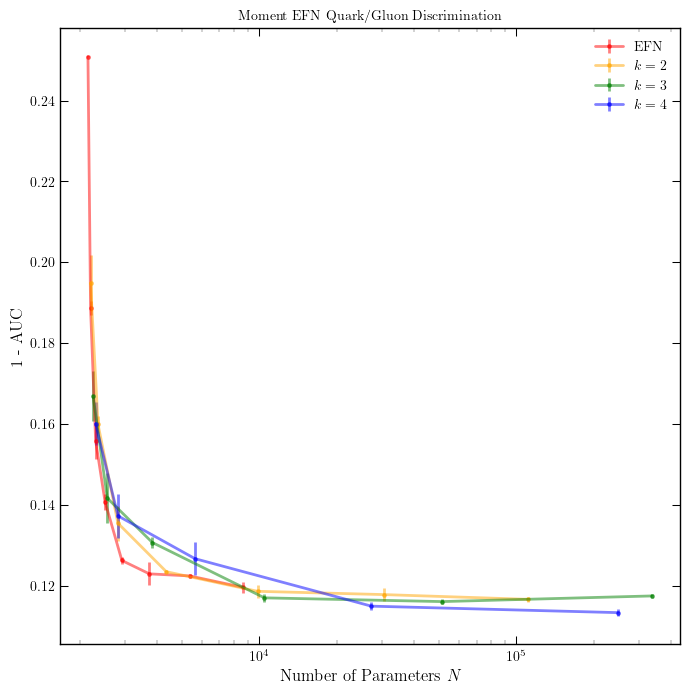

In [16]:

def num_params(input_dim, layers, output_dim):

    params = input_dim * (layers[0] + 1)
    for i in range(len(layers)-1):
        params = params + (layers[i])*(layers[i+1] +1)
    return params + (output_dim)*(layers[-1] + 1)


def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue", "purple", "black"]

    fig, axes = plt.subplots(figsize=(8,8))
    plt.rcParams['font.size'] = '20'


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):


            layers = [Phi_width, Phi_width, effective_latent_dim(order, config[0]), F_width, F_width, F_width]
            N = num_params(input_dim, layers, output_dim)
            
            x.append(N)
            print(config)
            # x.append(latent_dim(order,  config[0]))
            # x.append(effective_latent_dim(order,  config[0]))


            y.append(info[1])
            yerr.append(info[2])
            
        # axes.scatter(x, y,  marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5)
        x = np.asarray(x)
        y = np.asarray(y)
        # if p == 0:
        #     y = y * (1 - 1/(4*x))
        # yerr = np.asarray(yerr) 
        # if p == 0:
        #     # y = y * (1 - 1/(800*x))
        #     yerr = yerr * (1 + 1/(2*x))
        axes.errorbar(x,1 -y, yerr, marker = "o", c=colors[p], label = r'$k = %d$ ' % order if order > 1 else pfn_string, alpha = 0.5, lw = 2)


    # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])


    plt.legend(frameon = False)
    plt.xlabel(r"Number of Parameters $N$")
    plt.ylabel("1 - AUC")
    plt.xscale("log")
    # plt.ylim(.120, .325)
    plt.title(f"Moment {pfn_string} {dataset_string} Discrimination")

    plt.savefig(os.path.join(plot_directory, "num_parameters.pdf"))
    plt.show()


plot(performance)

# ROC Curve Information for tables


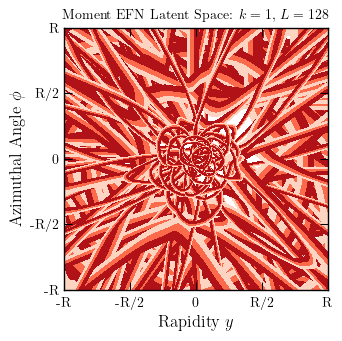

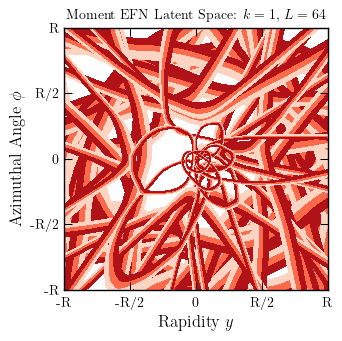

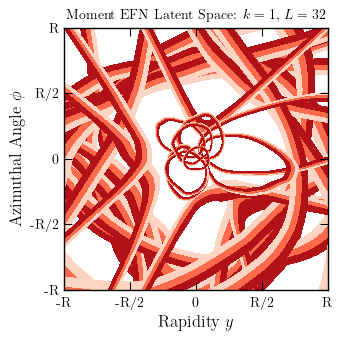

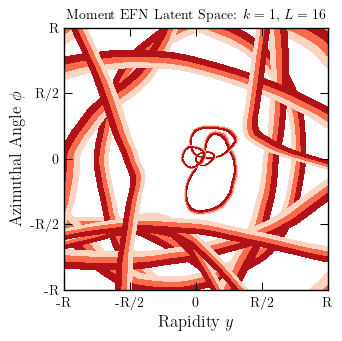

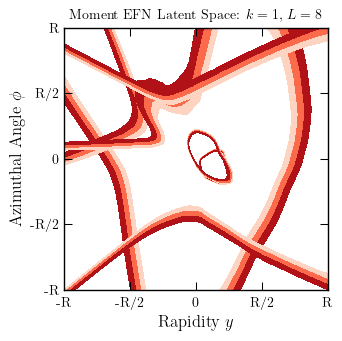

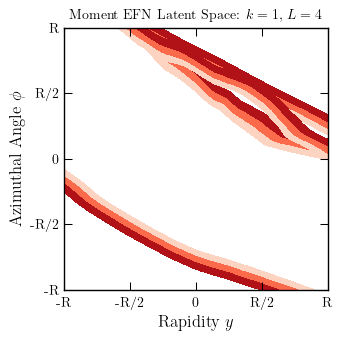

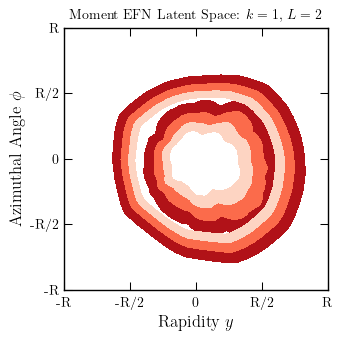

/tmp/ipykernel_5585/3863718494.py:88: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


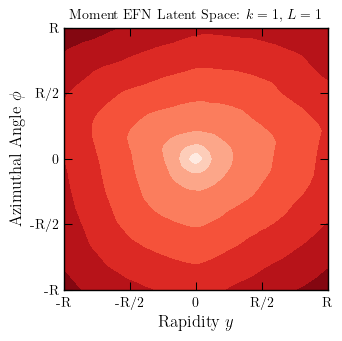

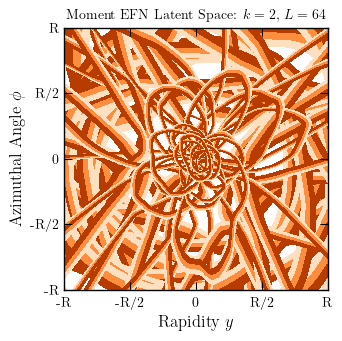

Could not load model Unable to open file (truncated file: eof = 262144, sblock->base_addr = 0, stored_eof = 415360)
Data/qg_EFN_latent/order_2/Models/O2_L32_2Phi100_3F100_1.keras


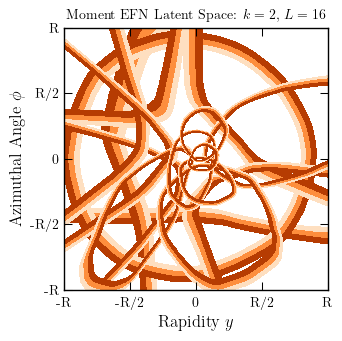

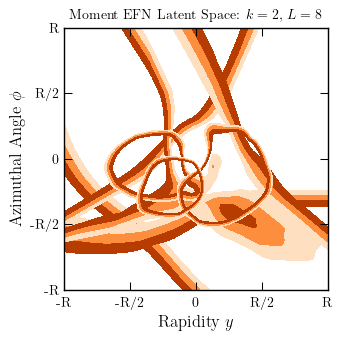

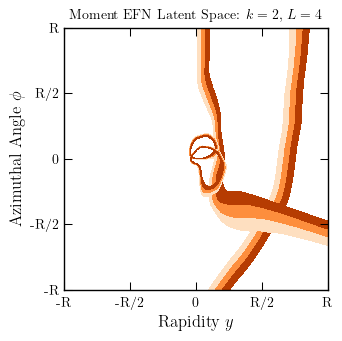

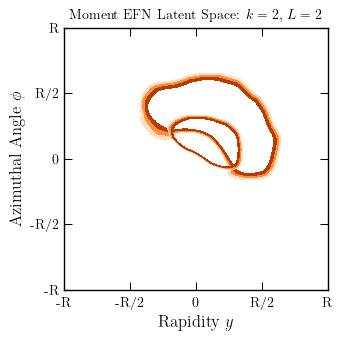

/tmp/ipykernel_5585/3863718494.py:88: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


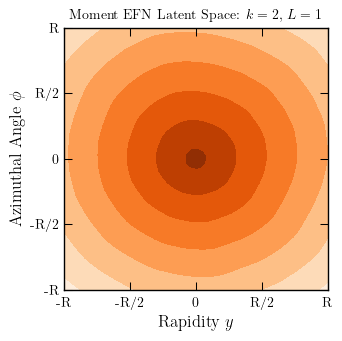

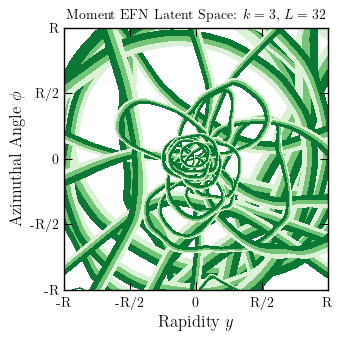

Could not load model Unable to open file (truncated file: eof = 262144, sblock->base_addr = 0, stored_eof = 566016)
Data/qg_EFN_latent/order_3/Models/O3_L16_2Phi100_3F100_1.keras


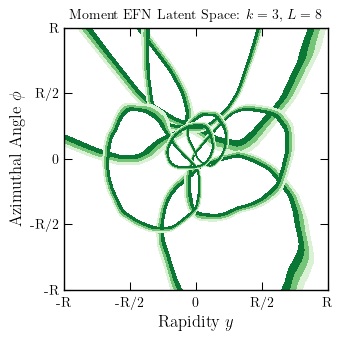

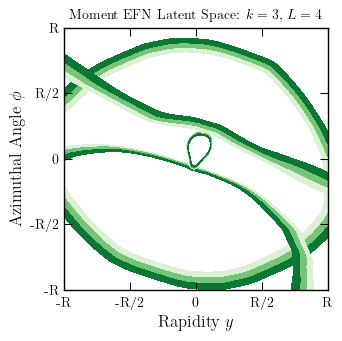

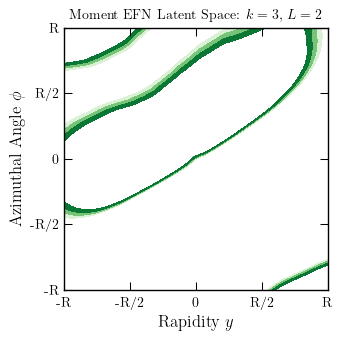

/tmp/ipykernel_5585/3863718494.py:88: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


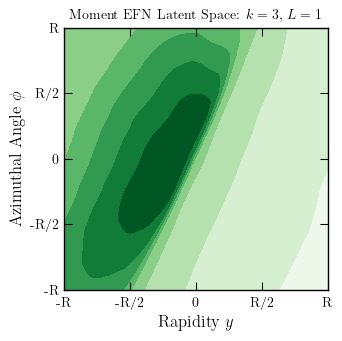

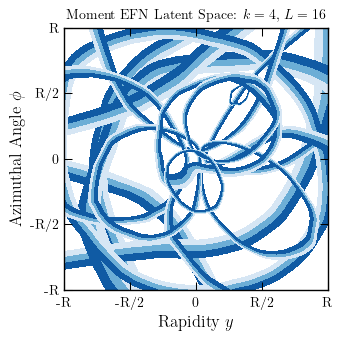

Could not load model Unable to open file (truncated file: eof = 262144, sblock->base_addr = 0, stored_eof = 371168)
Data/qg_EFN_latent/order_4/Models/O4_L8_2Phi100_3F100_1.keras


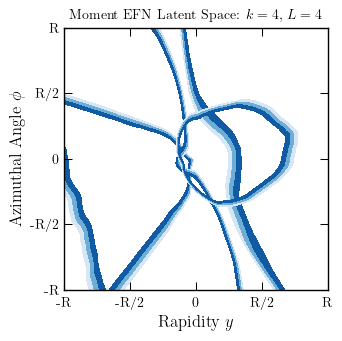

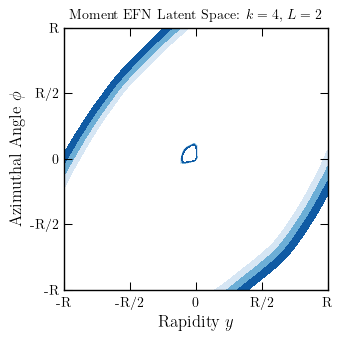

/tmp/ipykernel_5585/3863718494.py:88: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])


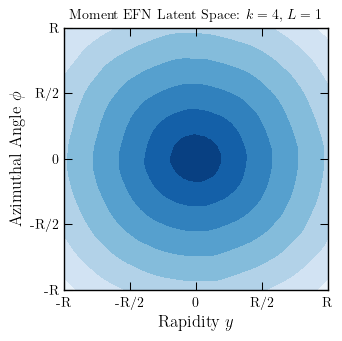

In [20]:

R, n = 0.4, 100

def plot(performance_dict):
    

    colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for (config,info) in zip(configs['Order '+str(order)], performance_dict['Order '+str(order)]):


            
            L, F, Phi = config

            # Load model
            dictionary = {'Phi_mapping_dim' : [input_dim,L],
                                        'output_dim' : 1, 'output_act' : 'sigmoid',
                                        'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" :  1e-6,
                                        'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                                        'order' : order , 'architecture_type':'moment',
                                        'loss': 'binary_crossentropy','metrics': 'acc',}
            model = EFN_moment(**dictionary, summary=False)
            model_dir = os.path.join(base_directory, f"order_{order}", "Models")
            model_name = f"O{order}_L{L}_2Phi{Phi}_3F{F}"

            try:
                model.load_weights(os.path.join(model_dir , model_name + "_1.keras"), by_name = True,  skip_mismatch = True)
            except Exception as e:
                print("Could not load model", e)
                print(os.path.join(model_dir , model_name + "_1.keras"))
                continue
            # ROC Curve

            


            # Filter Plotting
            X, Y, Z = model.eval_filters(R,n)
            subcolors = [colors[p]]


            fig, axes = newplot("column")

            grads = np.linspace(0.45, 0.55, 4)
            
            def format_filter(filt):

                size, angle = get_filter_size_and_position(filt)
                minus_size, minus_angle = get_filter_size_and_position(-1 * filt)

                if minus_angle < angle:
                    filt = -filt

                filt -= np.min(filt)
                filt /= np.max(filt)

                print(np.min(filt), np.max(filt))

                return filt
            
            # for sorting filters according to position
            def get_filter_size_and_position(filt, zfrac=0.5):   
                filt /= np.max(filt)
                maxind = np.argmax(filt)
                j, k = maxind//n, maxind%n

                angle = np.sqrt((j-n/2)**2 + (k-n/2)**2)*2/n
                size = np.count_nonzero(filt > zfrac)/n**2

                return size, angle

            sizes, angles = [], []
            for z in Z:
                size, angle = get_filter_size_and_position(z)
                sizes.append(size)
                angles.append(angle)
            qg_sizes, qg_angles = np.asarray(sizes), np.asarray(angles)

            # plot filters
            for i,z in enumerate(Z[np.argsort(qg_angles)[::-1]]):
                # z = format_filter(z)
                if L == 1 :
                    plt.contourf(X, Y, z/np.max(z), level = 25, cmap=subcolors[i % len(subcolors)])
                else:
                    plt.contourf(X, Y, z/np.max(z), grads, cmap=subcolors[i % len(subcolors)])


            plt.xticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
            plt.yticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
            plt.xlabel('Rapidity $y$')
            plt.ylabel('Azimuthal Angle $\phi$')
            plt.title(f'Moment EFN Latent Space: $k = {order}$, $L = {L}$', fontsize=10)

            # line_0 = f"Moment EFN Latent Space"
            # line_1 = r"$\textsc{PYTHIA}$ $8.215 + \textsc{DELPHES}$, $\sqrt{s} = 14$ TeV" if dataset == "top" else r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
            # line_2 = "$R = 0.8, p_T \in [550, 650]$ GeV" if dataset == "top" else "$R = 0.4, p_T \in [500, 550]$ GeV"
            # line_3 = rf"$k = {order}$, $L = {L}$"

            # stamp(0.05, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, delta_y= 0.06, textops_update={"horizontalalignment" : "left"})

            plt.savefig(os.path.join(latent_directory, f"latent_space_O{p}_L{L}.pdf"), bbox_inches = "tight")
            plt.show()
    # plt.show()


plot(performance)

/tmp/ipykernel_5585/1237100033.py:30: RuntimeWarning: invalid value encountered in log
  a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:])[0]


-3.584155306575718 -0.8466948586981768 0.005111233853731946


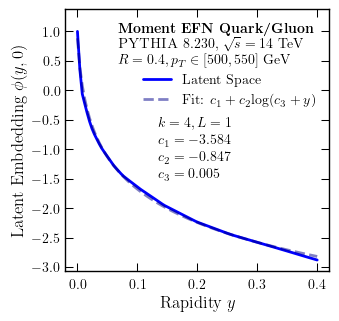

In [18]:
order = 4
L, F, Phi = 1, 100, 100

fig, ax = newplot("column")


# Load model
dictionary = {'Phi_mapping_dim' : [input_dim,L],
                            'output_dim' : 1, 'output_act' : 'sigmoid',
                            'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" :  1e-6,
                            'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                            'order' : order , 'architecture_type':'moment',
                            'loss': 'binary_crossentropy','metrics': 'acc',}
model = EFN_moment(**dictionary, summary=False)
model_dir = os.path.join(base_directory, f"order_{order}", "Models")
model_name = f"O{order}_L{L}_2Phi{Phi}_3F{F}"
model.load_weights(os.path.join(model_dir , model_name + "_0.keras"), by_name = True,  skip_mismatch = True)


X, Y, Z = model.eval_filters([0, 0, R, 0.000],n)

# print[Z[0,:,0]]
# plot filters
for i,z in enumerate(Z):

    x = X[:,0]
    y = z[:,0] / np.max(z[:,0])
    plt.plot(X[:,0], z[:,0] / np.max(z[:,0]), color = "blue", lw = 2, label = "Latent Space")

    a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:])[0]
    y_log = a + b*np.log(x + c)
    print(a, b, c)
    # b, a = np.polyfit(np.log(x[25:]), y[15:], 1)
    plt.plot(x[0:], y_log[0:], color = "darkblue", alpha = 0.5, lw = 2, ls = "--", label = "Fit: $c_1 + c_2$log$(c_3 + y)$")

    plt.text(0.35, 0.5-0.065*(-1), "$k = 4, L = 1$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    plt.text(0.35, 0.5-0.065*0, "$c_1 = %.3f$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    plt.text(0.35, 0.5-0.065*1, "$c_2 = %.3f$" % b, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    plt.text(0.35, 0.5-0.065*2, "$c_3 = %.3f$" % c, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# plt.xticks(np.linspace(0, R, 5), ['0', 'R/4' 'R/2', '3R/4', 'R'])
# plt.yticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
plt.xlabel('Rapidity $y$')
plt.ylabel('Latent Embdedding $\phi(y, 0)$')
# plt.title(f'Moment EFN Latent Space: $k = {order}$, $L = {L}$', fontdict={'fontsize': 20})
plt.legend(frameon = False, loc = "upper right", bbox_to_anchor=(1.0, 0.80))

# Stamp
add_whitespace(ax, upper_fraction=1.15,)
line_0 = f"Moment {pfn_string} {dataset_string}"
line_1 = "$PYTHIA$ $8.215$, $\sqrt{s} = 14$ TeV" if dataset == "top" else r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.8, p_T \in [500, 650]$ GeV" if dataset == "top" else "$R = 0.4, p_T \in [500, 550]$ GeV"

stamp(0.2, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={ "horizontalalignment" : "left"}, delta_y= 0.06)



plt.savefig(os.path.join(plot_directory, "latent_fit.pdf"), bbox_inches = "tight")


# L = 2

(2, 100, 100)
0.7222485969881215 0.13069075738237187 0.002547553071031517
1.2844937446700395 0.16289007201163766 -0.15002615588912696


/tmp/ipykernel_5585/1505167407.py:56: RuntimeWarning: invalid value encountered in log
  a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:])[0]


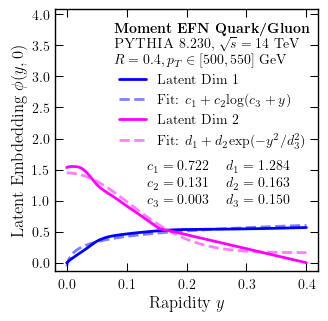

In [19]:
order = 4
L, F, Phi = 2, 100, 100


# Load model
dictionary = {'Phi_mapping_dim' : [input_dim,L],
                            'output_dim' : 1, 'output_act' : 'sigmoid',
                            'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU', "Phi_l1_regs" :  1e-6,
                            'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU', "F_l1_regs" :  1e-6,
                            'order' : order , 'architecture_type':'moment',
                            'loss': 'binary_crossentropy','metrics': 'acc',}
model = EFN_moment(**dictionary, summary=False)
model_dir = os.path.join(base_directory, f"order_{order}", "Models")
model_name = f"O{order}_L{L}_2Phi{Phi}_3F{F}"
model.load_weights(os.path.join(model_dir , model_name + "_2.keras"), by_name = True,  skip_mismatch = True)

X, Y, Z = model.eval_filters([0, 0, R, 0.000],n)
# X, Y, Z = model.eval_filters(R,n)



# for sorting filters according to position
def get_filter_size_and_position(filt, zfrac=0.5):   
    filt /= np.max(filt)
    maxind = np.argmax(filt)
    j, k = maxind//n, maxind%n

    angle = np.sqrt((j-n/2)**2 + (k-n/2)**2)*2/n
    size = np.count_nonzero(filt > zfrac)/n**2

    return size, angle

sizes, angles = [], []
for z in Z:
    size, angle = get_filter_size_and_position(z)
    sizes.append(size)
    angles.append(angle)
qg_sizes, qg_angles = np.asarray(sizes), np.asarray(angles)

# plot filters
print(Z.shape)

fig, ax = newplot("column")

latent_dim_colors = ["blue", "magenta"]
for i,z in enumerate(Z[np.argsort(qg_angles)[::-1]]):
        # newplot()
        # plt.contourf(X, Y, z/np.max(z), level = 25, cmap="Blues")

        x = X[:,0]
        y = z[:,0] / np.max(np.abs(z[:,0]))
        y = y - np.min(y) + 0.001
        plt.plot(X[:,0], y, color = latent_dim_colors[i], lw = 2, label = f"Latent Dim {i+1}")

        if i == 0:
            a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:])[0]
            y_log = a + b*np.log(x + c)
            plt.plot(x[0:], y_log[0:], color = latent_dim_colors[i], alpha = 0.5, lw = 2, ls = "--", label = "Fit: $c_1 + c_2$log$(c_3 + y)$")
            print(a, b, c)

            # plt.text(0.25, 0.5-0.065*(-1), "$k = 4, L = 2$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            plt.text(0.35, 0.4-0.065*0, "$c_1 = %.3f$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            plt.text(0.35, 0.4-0.065*1, "$c_2 = %.3f$" % b, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            plt.text(0.35, 0.4-0.065*2, "$c_3 = %.3f$" % c, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

        elif i == 1:


            a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: b + a*np.exp(-(t)**2/c**2),  x[0:],  y[0:], p0 = (0.5, 0.1, 1))[0]
            # a, b, c = 1.5, 0.01, 0.125
            y_log = b + a*np.exp(-(x)**2/c**2)
            print(a, b, c)
        # b, a = np.polyfit(np.log(x[25:]), y[15:], 1)
            plt.plot(x[0:], y_log[0:], color = latent_dim_colors[i], alpha = 0.5, lw = 2, ls = "--", label = "Fit: $d_1 + d_2$exp$(-y^2/d_3^2)$")

            plt.text(0.65, 0.4-0.065*0, "$d_1 = %.3f$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            plt.text(0.65, 0.4-0.065*1, "$d_2 = %.3f$" % b, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
            plt.text(0.65, 0.4-0.065*2, "$d_3 = %.3f$" % np.abs(c), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)



# Stamp
add_whitespace(ax, upper_fraction=2.5,)
line_0 = f"Moment {pfn_string} {dataset_string}"
line_1 = "$PYTHIA$ $8.215$, $\sqrt{s} = 14$ TeV" if dataset == "top" else r"$\textsc{PYTHIA}$ $8.230$, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.8, p_T \in [500, 650]$ GeV" if dataset == "top" else "$R = 0.4, p_T \in [500, 550]$ GeV"

stamp(0.225, 0.925, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={ "horizontalalignment" : "left"}, delta_y= 0.06)



plt.legend(frameon = False, loc = "upper right", bbox_to_anchor=(1.0, 0.80))

plt.xlabel('Rapidity $y$')
plt.ylabel('Latent Embdedding $\phi(y, 0)$')

plt.savefig(os.path.join(plot_directory, "latent_fit_2.pdf"), bbox_inches = "tight")


# # print[Z[0,:,0]]
# # plot filters
# for i,z in enumerate(Z):

    
#     x = X[:,0]
#     y = z[:,0] / np.max(z[:,0])
#     plt.plot(X[:,0], z[:,0] / np.max(z[:,0]), color = "blue", lw = 3, label = "Latent Space")

#     a, b, c = scipy.optimize.curve_fit(lambda t,a,b,c: a+b*np.log(c + t),  x[0:],  y[0:])[0]
#     y_log = a + b*np.log(x + c)
#     print(a, b, c)
#     # b, a = np.polyfit(np.log(x[25:]), y[15:], 1)
#     plt.plot(x[0:], y_log[0:], color = "darkblue", alpha = 0.5, lw = 3, ls = "--", label = "Fit: $c_1 + c_2$log$(c_3 + y)$")

#     plt.text(0.375, 0.605-0.065*(-1), "$k = 4, L = 1$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
#     plt.text(0.375, 0.605-0.065*0, "$c_1 = %.3f$" % a, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
#     plt.text(0.375, 0.605-0.065*1, "$c_2 = %.3f$" % b, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
#     plt.text(0.375, 0.605-0.065*2, "$c_3 = %.3f$" % c, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

# # plt.xticks(np.linspace(0, R, 5), ['0', 'R/4' 'R/2', '3R/4', 'R'])
# # plt.yticks(np.linspace(-R, R, 5), ['-R', '-R/2', '0', 'R/2', 'R'])
# plt.xlabel('Rapidity $y$')
# plt.ylabel('Latent Embdedding $\phi(y, 0)$')
# # plt.title(f'Moment EFN Latent Space: $k = {order}$, $L = {L}$', fontdict={'fontsize': 20})
# plt.legend(frameon = False, loc = "upper right", bbox_to_anchor=(1.0, 0.85))

# # Stamp
# add_whitespace(ax, upper_fraction=1.15,)
# line_0 = f"Moment {pfn_string} {dataset_string}"
# line_1 = "$PYTHIA$ $8.215$, $\sqrt{s} = 14$ TeV" if dataset == "top" else "$PYTHIA$ $8.230$, $\sqrt{s} = 14$ TeV"
# line_2 = "$R = 0.8, p_T \in [500, 650]$ GeV" if dataset == "top" else "$R = 0.4, p_T \in [500, 550]$ GeV"

# stamp(0.95, 0.95, line_0 = line_0, line_1 = line_1, line_2 = line_2, textops_update={"fontsize" : 18, "horizontalalignment" : "right"})



# plt.savefig(os.path.join(plot_directory, "latent_fit.pdf"))
